# ARIMA时间序列分析

## 读取数据

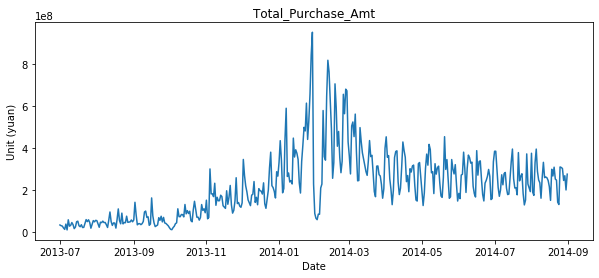

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

user_balance = pd.read_csv('user_balance_table.csv')

df_tmp = user_balance.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
df_tmp.reset_index(inplace=True)

df_tmp['report_date'] = pd.to_datetime(df_tmp['report_date'], format='%Y%m%d')

df_tmp.index = df_tmp['report_date']

total_purchase_amt = plt.figure(figsize=(10, 4))
ax = total_purchase_amt.add_subplot(111)
ax.set(title='Total_Purchase_Amt',
       ylabel='Unit (yuan)', xlabel='Date')
plt.plot(df_tmp['report_date'], df_tmp['total_purchase_amt'])
plt.show()

取2014-04-01到2014-07-31的数据作为训练集，将2014-08-01到2014-08-10的数据作为测试集：

In [3]:
def generate_purchase_seq():
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
    user_balance = pd.read_csv('./user_balance_table.csv', parse_dates=['report_date'],
                               index_col='report_date', date_parser=dateparse)

    df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()
    purchase_seq = pd.Series(df, name='value')

    purchase_seq_train = purchase_seq['2014-04-01':'2014-07-31']
    purchase_seq_test = purchase_seq['2014-08-01':'2014-08-10']

    purchase_seq_train.to_csv(path='./purchase_seq_train.csv', header=True)
    purchase_seq_test.to_csv(path='./purchase_seq_test.csv', header=True)


generate_purchase_seq()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  del sys.path[0]


## 平稳性ADF检验

查看训练集的差分效果，并对每一次的差分结果做ADF检验：

timeseries_adf :  (-2.06397475117699, 0.2592449964335153, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4191.005978668395)
timeseries_diff1_adf :  (-6.542516143607562, 9.270661450976668e-09, 12, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, 4193.843107210291)
timeseries_diff2_adf :  (-5.615545867454458, 1.1766955956631024e-06, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4222.922633673087)


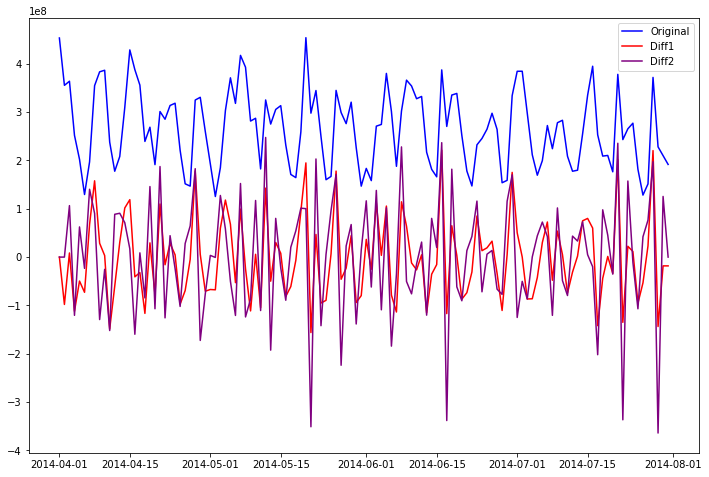

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries['value'].tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1['value'].tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2['value'].tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

diff(purchase_seq_train)
  

第一个结果是ADF值，第二个结果是P值，通过对P值进行检验，是否小于阀值0.05.由上结果看出原序列不平稳，一阶差分后才平稳。对原序列做一阶差分，并查看差分后的ACF,PACF:

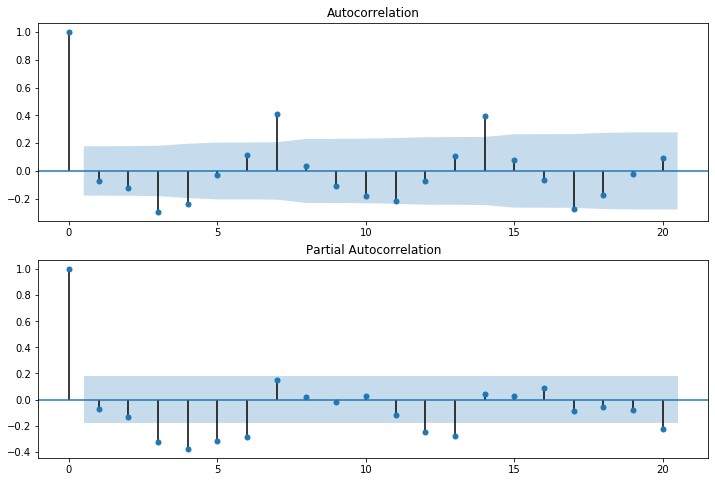

In [6]:
def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_train_diff = purchase_seq_train.diff(1)
purchase_seq_train_diff = purchase_seq_train_diff.fillna(0)

autocorrelation(purchase_seq_train_diff, 20)
  


* 拖尾：序列以指数率单调递减或者震荡衰减。
* 截尾：序列从某个时间点变得非常小。

从上图序列ACF（自相关系数）和PACF（偏自相关系数）的图中没有发现明显的拖尾或者截尾，说明对于这样的序列，不适合用ARIMA模型来拟合。那怎么办呢？我们先通过对时间序列分解（STL），再用ARIMA模型来拟合趋势序列和残差序列。


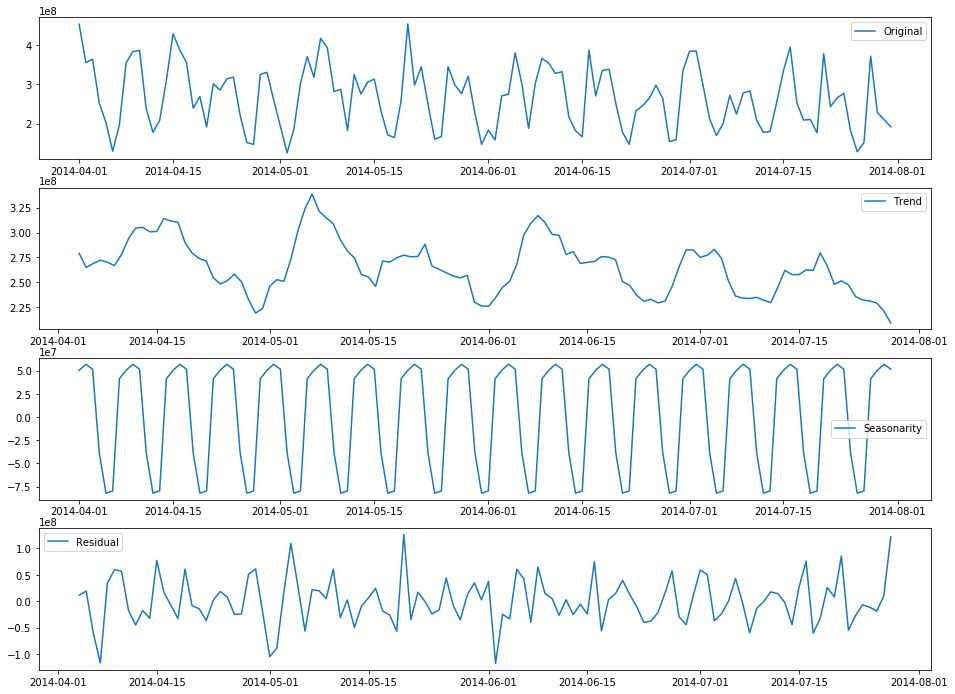

In [8]:
#对原序列分解
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

decomposing(purchase_seq_train)
  


从上图可以看出，原序列有明显的周期性，我们只对原序列的趋势序列和残差序列去拟合，同时认为周期性会延伸到测试集的时间。下面对趋势序列和残差序列进行拟合,即差分，并计算ADF：

timeseries_adf :  (-3.2368487584485877, 0.017948383665881536, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 3971.5751227480287)
timeseries_diff1_adf :  (-10.571816201699768, 7.2723798146224e-19, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 3970.0252957725997)
timeseries_diff2_adf :  (-5.522044427904818, 1.8681654787398006e-06, 8, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 3975.173191562041)


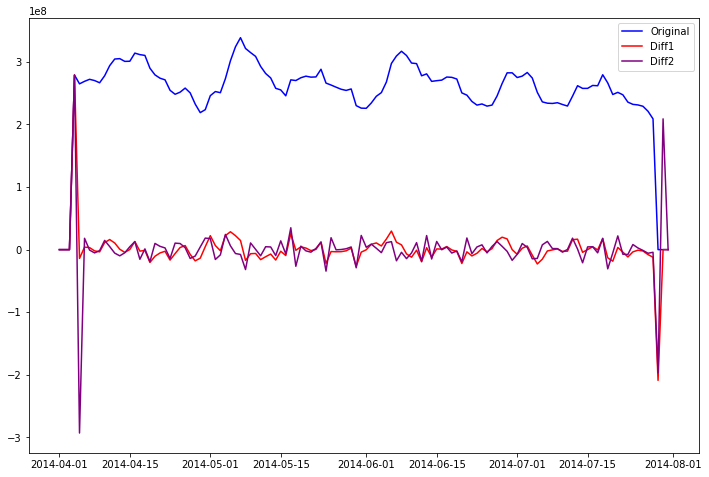

timeseries_adf :  (-6.29021210464834, 3.614727756796546e-08, 8, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 4080.577975834708)
timeseries_diff1_adf :  (-5.903150268380973, 2.747737630041955e-07, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4107.235275181308)
timeseries_diff2_adf :  (-6.644726878644903, 5.300796399129797e-09, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4137.527983157888)


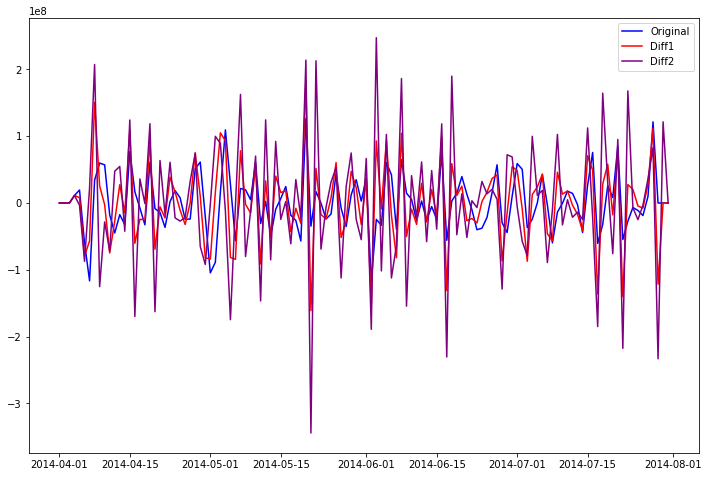

In [9]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

diff(trend)

diff(residual)


从ADF的检验结果来看，序列趋势和残差序列都已经比较平稳（P值小于0.05），因此不需要差分，再看一下ACF和PACF:

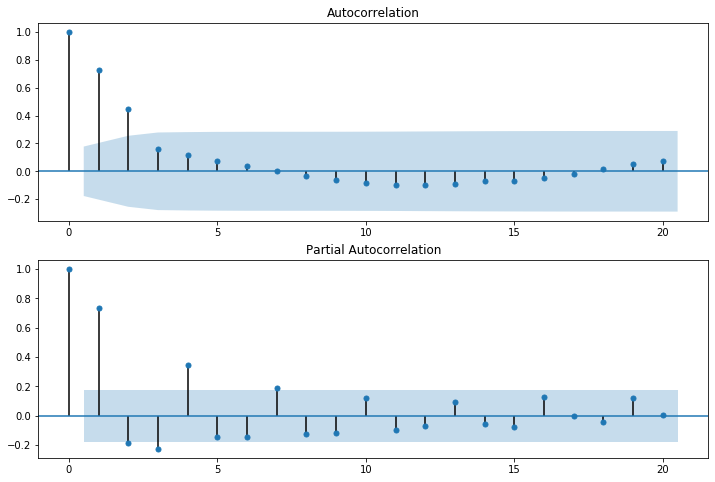

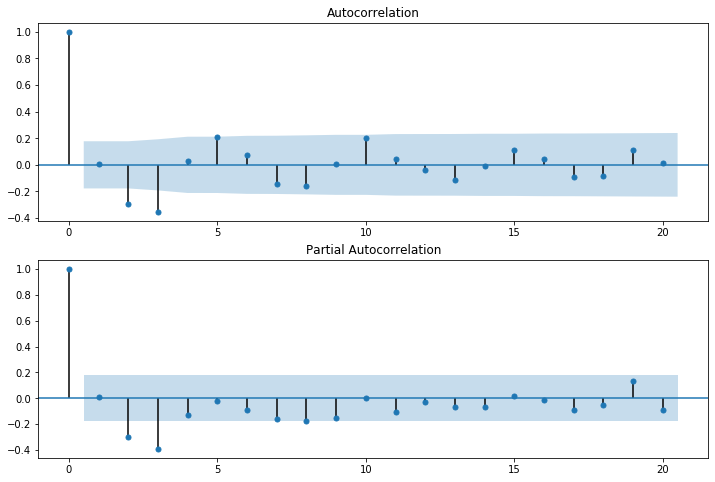

In [11]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

autocorrelation(trend, 20)

autocorrelation(residual, 20)

由上图看出：
* 趋势序列ACF有3阶截尾，PACF有2阶拖尾，因此可选p=2,q=3.
* 残差序列ACF有4阶拖尾，PACF有4阶截尾，因此可选p=4,q=4.

通过拖尾和截尾对模型定阶，有很强的主观性。而可以通过信息准则函数，来确定模型的阶数。这里用AIC,BIC(AIC,BIC是和模型的最大似然L,数据量n,模型的变量个数K有关的信息准则。:



In [13]:
ateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

trend_evaluate = sm.tsa.arma_order_select_ic(trend, ic=['aic', 'bic'], trend='nc', max_ar=4,
                                            max_ma=4)
print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)

residual_evaluate = sm.tsa.arma_order_select_ic(residual, ic=['aic', 'bic'], trend='nc', max_ar=4,
                                            max_ma=4)
print('residual AIC', residual_evaluate.aic_min_order)
print('residual BIC', residual_evaluate.bic_min_order)

  


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


trend AIC (1, 0)
trend BIC (1, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


residual AIC (2, 1)
residual BIC (2, 1)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


从评估结果来看（这里采用AIC结果，因为样本容量不是很大）：
* 对序列趋势，p=1,q=0
* 对残差序列，p=2,q=1

下面，分别训练趋势序列和残差序列的ARIMA模型，并结合原序列的周期，拟合训练数据集，并预测测试集数据。

* 对于训练集，拟合序列=周期序列+趋势序列（ARIMA拟合）+残差序列（ARIMA拟合）
* 对于测试集，预测序列=周期序列+趋势序列（ARIMA预测）+残差序列（ARIMA预测）



C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


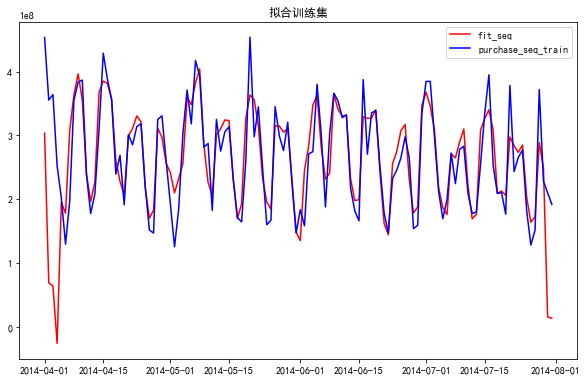

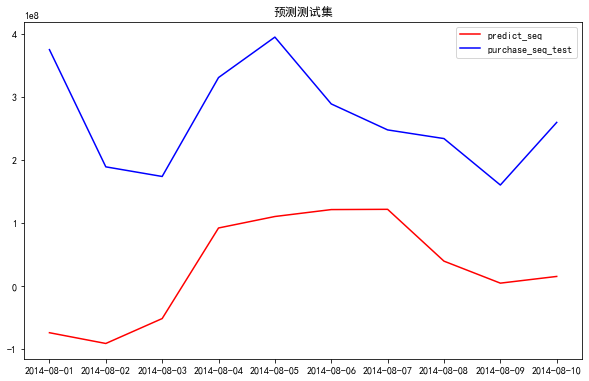

In [21]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit(disp=0)

#disp:是否打印中间过程
#order:The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_test = pd.read_csv('./purchase_seq_test.csv', parse_dates=['report_date'],
                                index_col='report_date', date_parser=dateparse)


decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

# 趋势序列模型训练
trend_model = ARIMA_Model(trend, (1, 0, 0))
trend_fit_seq = trend_model.fittedvalues
trend_predict_seq = trend_model.predict(start='2014-08-01', end='2014-08-10', dynamic=True)

# 残差序列模型训练
residual_model = ARIMA_Model(residual, (2, 0, 1))
residual_fit_seq = residual_model.fittedvalues
residual_predict_seq = residual_model.predict(start='2014-08-01', end='2014-08-10', dynamic=True)

# 拟合训练集
fit_seq = pd.Series(seasonal['value'], index=seasonal.index)
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

plt.figure(figsize=(10, 6.2))
plt.plot(fit_seq, color='red', label='fit_seq')
plt.plot(purchase_seq_train, color='blue', label='purchase_seq_train')
plt.legend(loc='best')

plt.title('拟合训练集',fontweight='heavy')
plt.show()

# 预测测试集
# 这里测试数据的周期性是根据seasonal对象打印的结果，看到里面的数据每7天一个周期，2014-08-01~2014-08-10的数据正好和2014-04-04~2014-04-13的数据一致
seasonal_predict_seq = seasonal['2014-04-04':'2014-04-13']

predict_dates = pd.Series(
    ['2014-08-01', '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05', '2014-08-06', '2014-08-07', '2014-08-08',
     '2014-08-09', '2014-08-10']).apply(lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'))

seasonal_predict_seq.index = predict_dates

predict_seq = pd.Series(seasonal_predict_seq['value'], index=seasonal_predict_seq.index)
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

plt.figure(figsize=(10, 6.2))
plt.plot(predict_seq, color='red', label='predict_seq')
plt.plot(purchase_seq_test, color='blue', label='purchase_seq_test')
plt.legend(loc='best')
plt.title('预测测试集',fontweight='heavy')
plt.show()
  


从上图可以看出：
* 训练集上的拟合还是不错的
* 测试机上，基本上预测了序列的趋势和波动（但是在数值上有小小差异，原因在于这样的数据集不适合ARIMA来拟合，因为序列的自相关性不强，受随机噪声影响不较大）

In [23]:
# 求RMSE
#from sklearn.metrics import mean_squared_error
#from math import sqrt

#rms = sqrt(mean_squared_error(purchase_seq_test, predict_seq))
